# INTRODUCTION

This ongoing Python project analyzes the relationship between socio-economic factors and opioid overdose deaths across counties in New York State. The analysis explores variables such as poverty rates, high school dropout rates, mental health, and healthcare access to determine their predictive power regarding opioid-related fatalities, with the aim of uncovering insights that can inform public health strategies and interventions.

*Note: This is a work in progress. Given the complexity of the opioid crisis, there are still many more factors to explore.*

*Next steps: explore unemployment rates as a predictor*

# IMPORTS

In [3]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pingouin as pg

# LOAD DATA

In [5]:
path = './data/'

opioids = pd.read_csv(path + 'OP-CountyData.xlsx - Opioid dashboard - Mortality.csv') # from https://apps.health.ny.gov/public/tabvis/PHIG_Public/opioid/#dataexport
dropouts = pd.read_csv(path + 'Community_Health__Percentage_of_High_School_Drop_Outs_by_County_Map__Latest_Data.csv') # from https://www.data.ny.gov/ru/browse?q=dropout&sortBy=relevance
poverty = pd.read_csv(path + '2019_nys_poverty_rates.csv') # from https://www.census.gov/data/datasets/2019/demo/saipe/2019-state-and-county.html
mental_health_healthcare = pd.read_csv(path + 'Behavioral_Risk_Factor_Surveillance_System__BRFSS__Health_Indicators_by_County_and_Region_20240806.csv') # from https://www.health.ny.gov/statistics/brfss/ Data available from 2018, 2021. Using 2018 since 2021 may be swayed by covid

# CLEANING OPIOID DATASET

In [7]:
opioids = opioids[opioids['Data Years'] == 2019]
opioids = opioids[opioids['Indicator Number'] == 'opd3']
opioids = opioids[~opioids['County Name'].isin([
    'New York State',
    'New York State (excluding NYC)',
    'New York City',
    'Long Island',
    'Mid-Hudson',
    'Western NY',
    'Mohawk Valley',
    'Finger Lakes',
    'Central Region',
    'Capital Region',
    'Central NY',
    'North Country',
    'Southern Tier',
    'Tug Hill Seaway'
])] # remove already-aggregated rows

opioids.loc[opioids['Event Count/Rate'] == 's', ['Event Count/Rate', 'Percentage/Rate']] = '0'

# Event Count/Rate of 's' indicates that the numbers are not high enough to count
# Same for Percentage/Rate
# (source: https://oasas.ny.gov/system/files/documents/2022/09/hamilton_county_key_sud_indicators_06152022.pdf)
# I can safely replace them with 0's

opioids.loc[:,'Percentage/Rate'] = opioids['Percentage/Rate'].str.replace('*', '')

opioids[['Event Count/Rate', 'Percentage/Rate']] = opioids[['Event Count/Rate', 'Percentage/Rate']].apply(pd.to_numeric)
opioids = opioids.drop(columns=['Priority Area', 'Indicator Number', 'Indicator','Data Years', 'Date Source'])
opioids = opioids.loc[:,['Region','County Name','Event Count/Rate','Percentage/Rate']]
opioids = opioids.rename(columns={'Event Count/Rate':'Opioid Deaths', 'Percentage/Rate':'Opioid Deaths per 100000'})
# opioids now stands for: opioid overdose deaths per 100000 people in 2019, by county

# CLEANING DROPOUTS DATA

In [9]:
# dropouts: 2015-2017 dropout rates by county
dropouts = dropouts[['County Name', 'Event Count', 'Percent/Rate']]
dropouts = dropouts.rename(columns={'Event Count':'Dropouts', 'Percent/Rate':'Dropout Percentage'})
dropouts[['Dropouts','Dropout Percentage']] = dropouts[['Dropouts','Dropout Percentage']].fillna(0)
# NAs here indicate there isn't enough data. Just for Hamilton county, it seems, same as for opioids.
# Fill with 0's for now, but keep in mind that Hamilton county (the lowest populated county in NYS) is a potential outlier
# Maybe just remove it later.

# CLEANING POVERTY DATA

In [11]:
poverty = poverty.loc[:,['County Name', 'Poverty Count', 'Poverty Percentage']]
poverty.loc[:,'County Name'] = poverty['County Name'].str.strip()
poverty = poverty[poverty['County Name'] != 'New York'] # Filter out aggregate data for state. Leaves in New York County.
poverty.loc[:,'County Name'] = poverty['County Name'].str.replace(' County', '')

# CLEANING MENTAL HEALTH

In [13]:
poor_mental_health = mental_health_healthcare[mental_health_healthcare['Health Indicator Short Name'] == 'Poor Mental Health']
poor_mental_health = poor_mental_health[poor_mental_health['Year'] == '2018']
poor_mental_health = poor_mental_health[poor_mental_health['Geography'] == 'County']
poor_mental_health = poor_mental_health[['Region/County', 'Crude Rate']]
poor_mental_health = poor_mental_health.rename(columns={'Region/County':'County Name','Crude Rate':'Poor Mental Health Percentage'})

# Poor Mental Health Percentage is percentage of adults in 2018 who reported 14 or more
# bad mental health days per month, according to the BRFSS codebook here:
# https://www.cdc.gov/brfss/annual_data/2021/pdf/2021-calculated-variables-version4-508.pdf

# CLEANING HEALTHCARE DATA

In [15]:
healthcare = mental_health_healthcare[mental_health_healthcare['Health Indicator Short Name'].isin(['No Medical Care Due to Cost','Recent Checkup'])]
healthcare = healthcare[healthcare['Year'] == '2018']
healthcare = healthcare[healthcare['Geography'] == 'County']
healthcare = healthcare[['Region/County', 'Health Indicator Short Name', 'Crude Rate']]

no_med_care = healthcare[healthcare['Health Indicator Short Name'] == 'No Medical Care Due to Cost']
no_med_care = no_med_care.rename(columns={'Crude Rate':'No Medical Care Due to Cost Percentage'})

checkup = healthcare[healthcare['Health Indicator Short Name'] == 'Recent Checkup']
checkup = checkup.rename(columns={'Crude Rate':'Recent Checkup Percentage'})

# Keep the two indicators in one table to work with more efficiency

healthcare = pd.merge(checkup[['Region/County','Recent Checkup Percentage']],
                     no_med_care[['Region/County','No Medical Care Due to Cost Percentage']],
                     on='Region/County')
healthcare = healthcare.rename(columns={'Region/County':'County Name'})


# No Medical Care Due to Cost is the percentage of people in 2018 who, in the previous year, needed
# to see a doctor but couldn't due to cost, according to the BRFSS codebook here:
# https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf

# Checkup Within Past Year is the percentage of adults aged 18-64 in 2018 who saw a doctor for
# a routine checkup within the last year

# MERGING DATA

In [17]:
opioids_factors = opioids.merge(dropouts, on='County Name')
opioids_factors = opioids_factors.merge(poverty, on='County Name')
opioids_factors = opioids_factors.merge(poor_mental_health, on='County Name')
opioids_factors = opioids_factors.merge(healthcare, on='County Name')

# UNIVARIATE ANALYSIS

C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


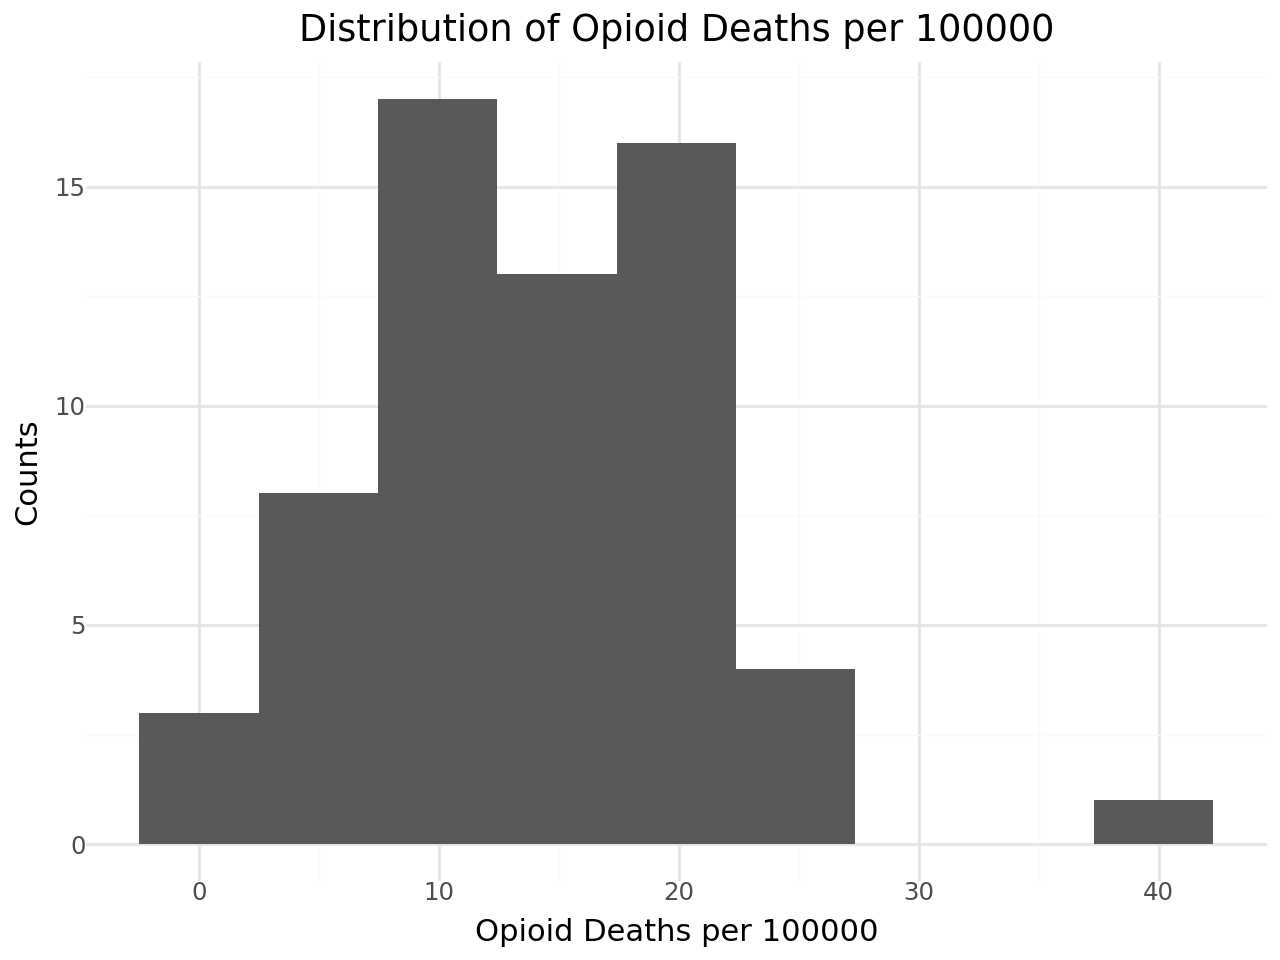

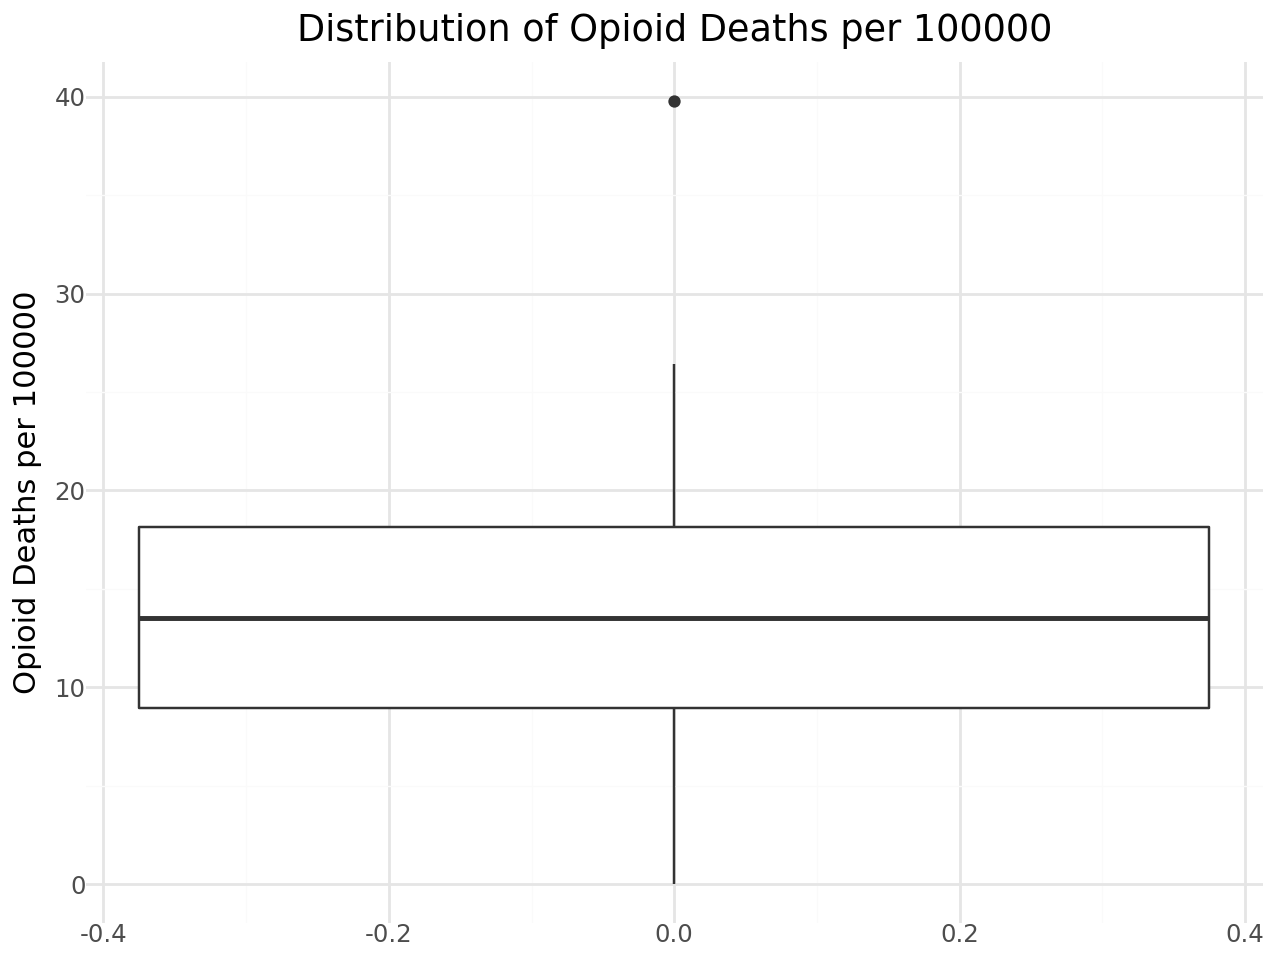

count    62.00
mean     13.74
std       7.30
min       0.00
25%       8.95
50%      13.50
75%      18.15
max      39.80
Name: Opioid Deaths per 100000, dtype: float64


C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


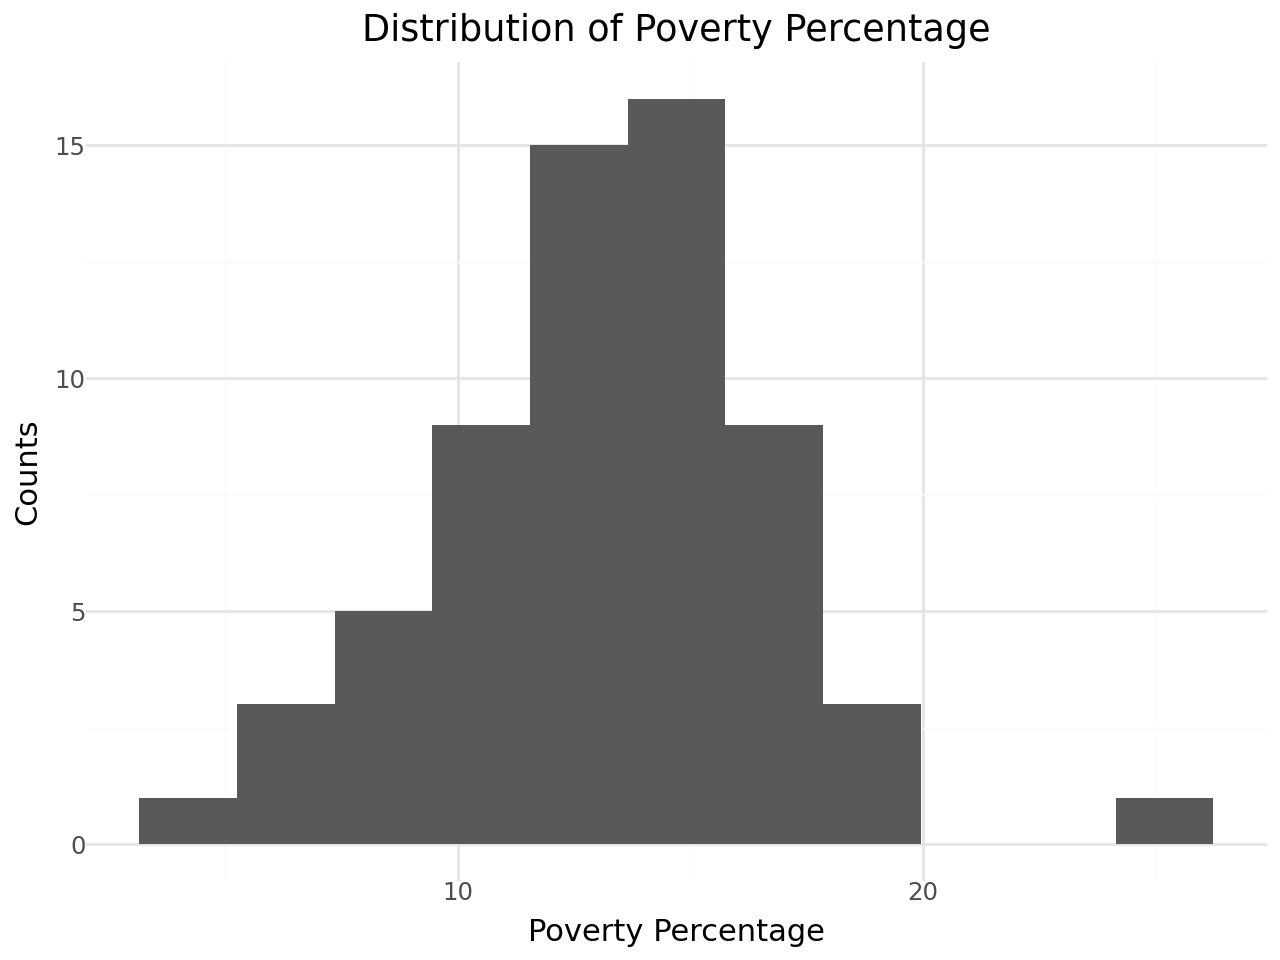

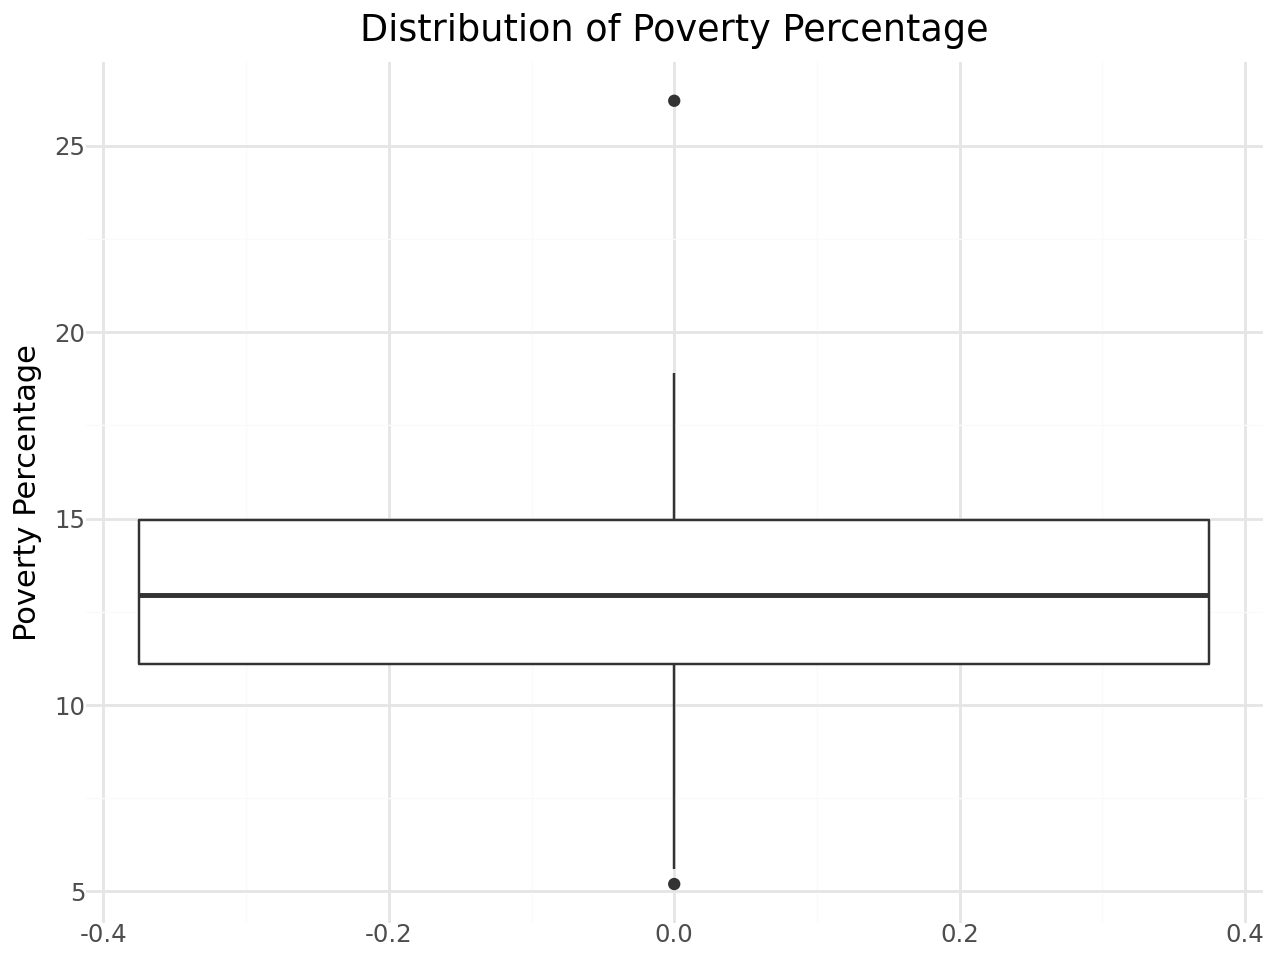

count    62.00
mean     13.05
std       3.60
min       5.20
25%      11.10
50%      12.95
75%      14.95
max      26.20
Name: Poverty Percentage, dtype: float64


C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


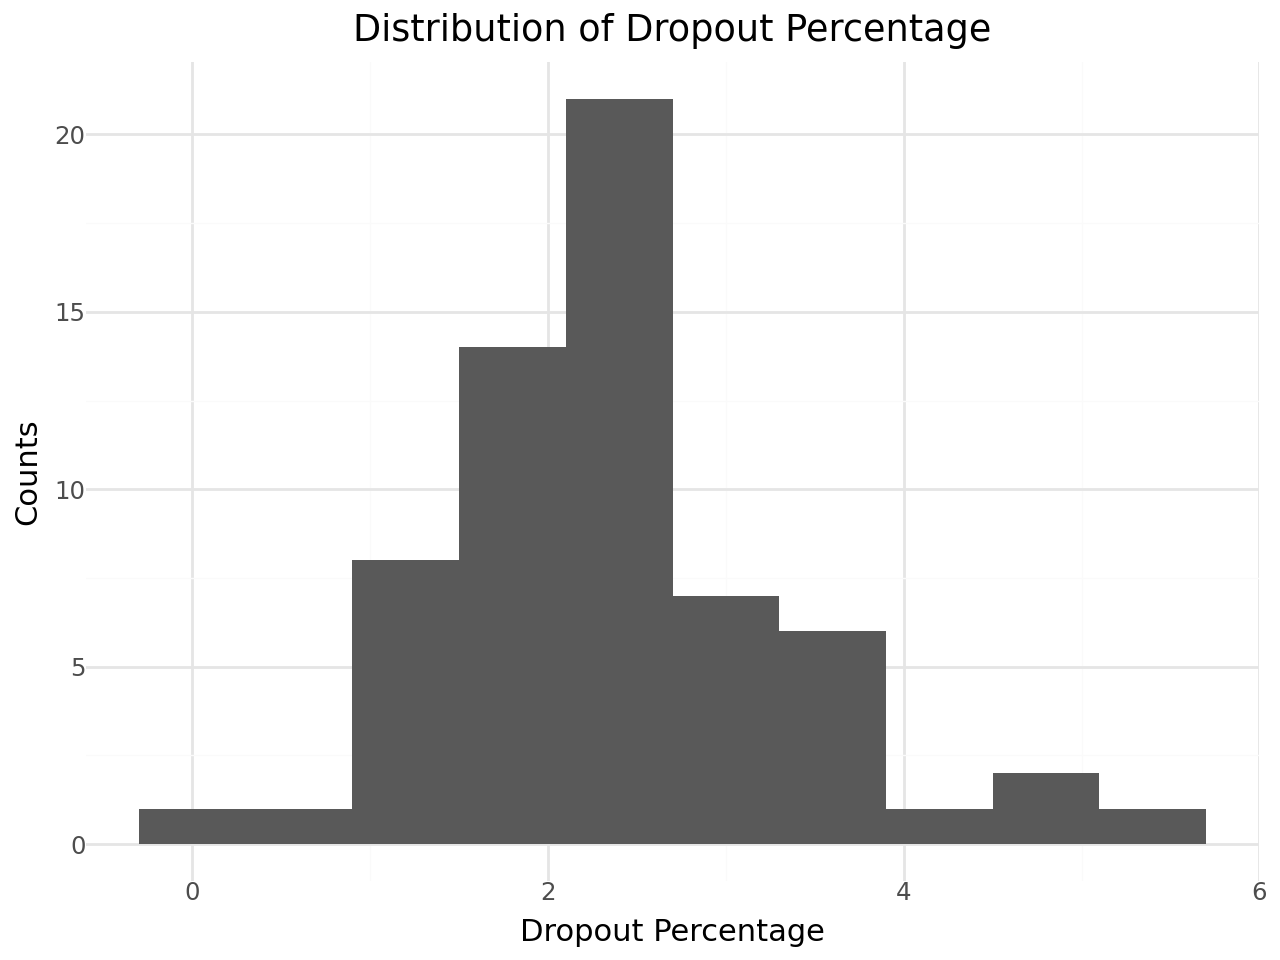

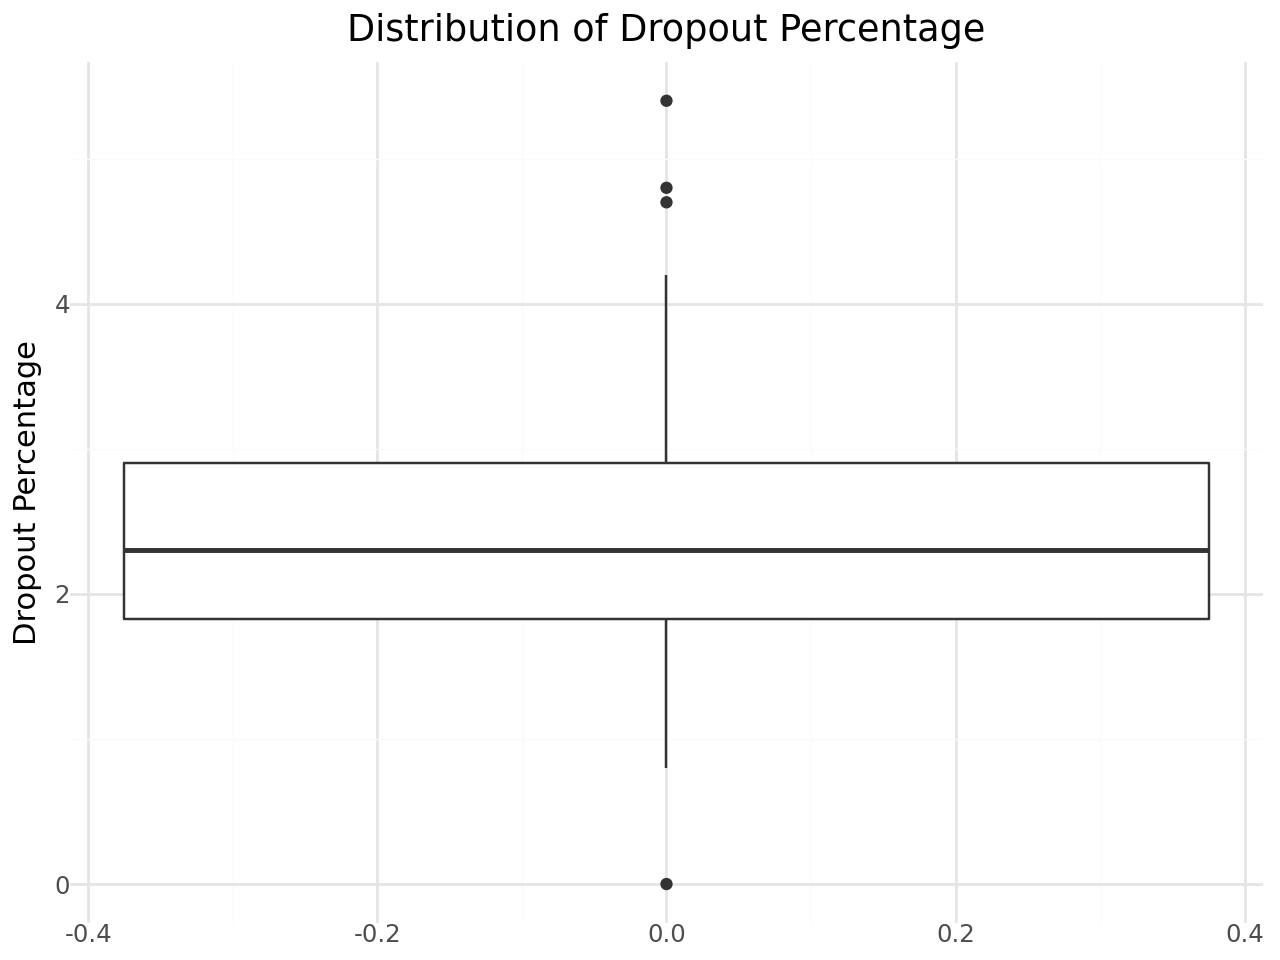

count    62.00
mean      2.45
std       0.98
min       0.00
25%       1.82
50%       2.30
75%       2.90
max       5.40
Name: Dropout Percentage, dtype: float64


C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


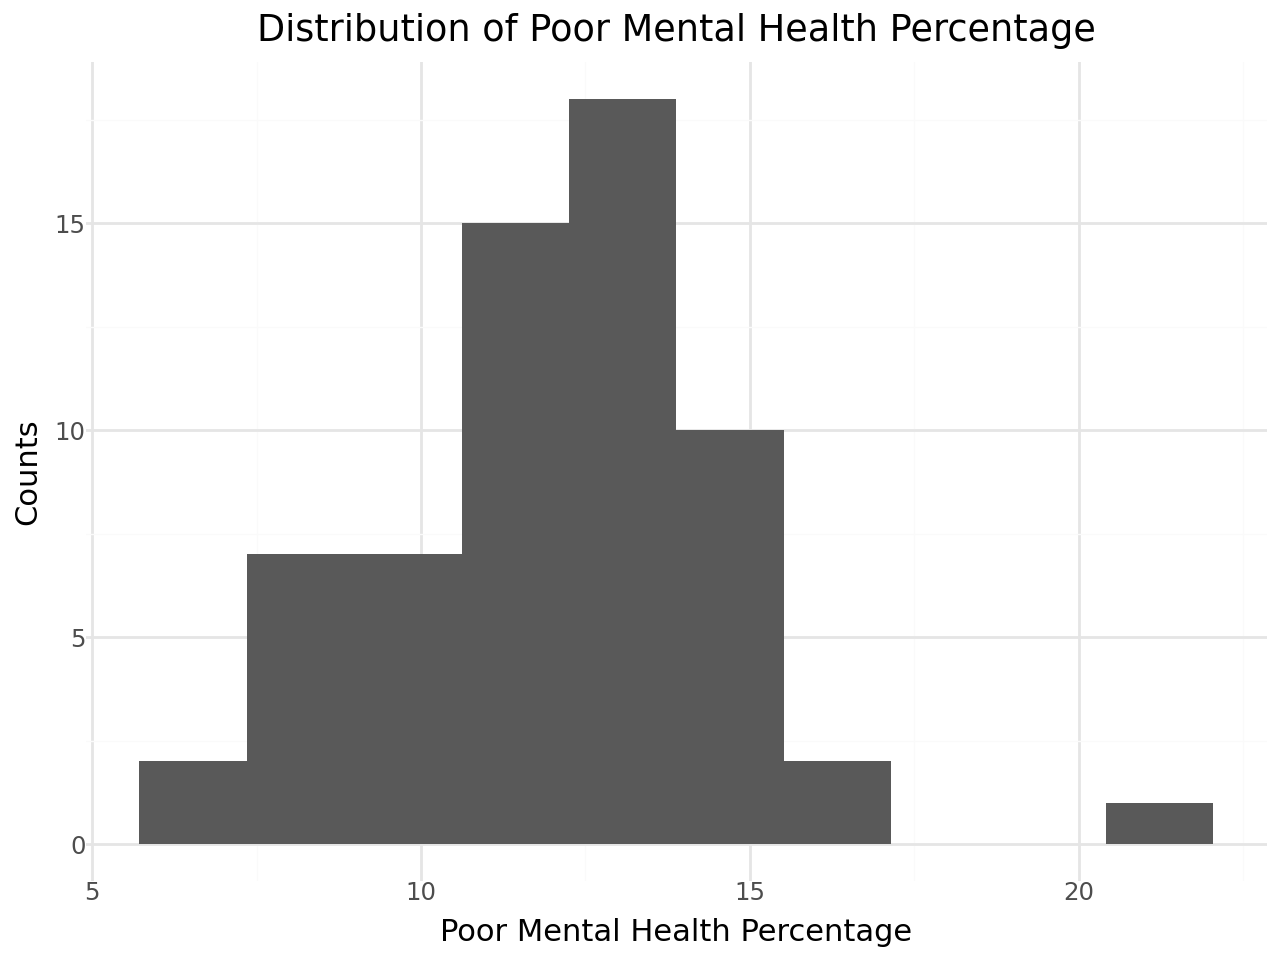

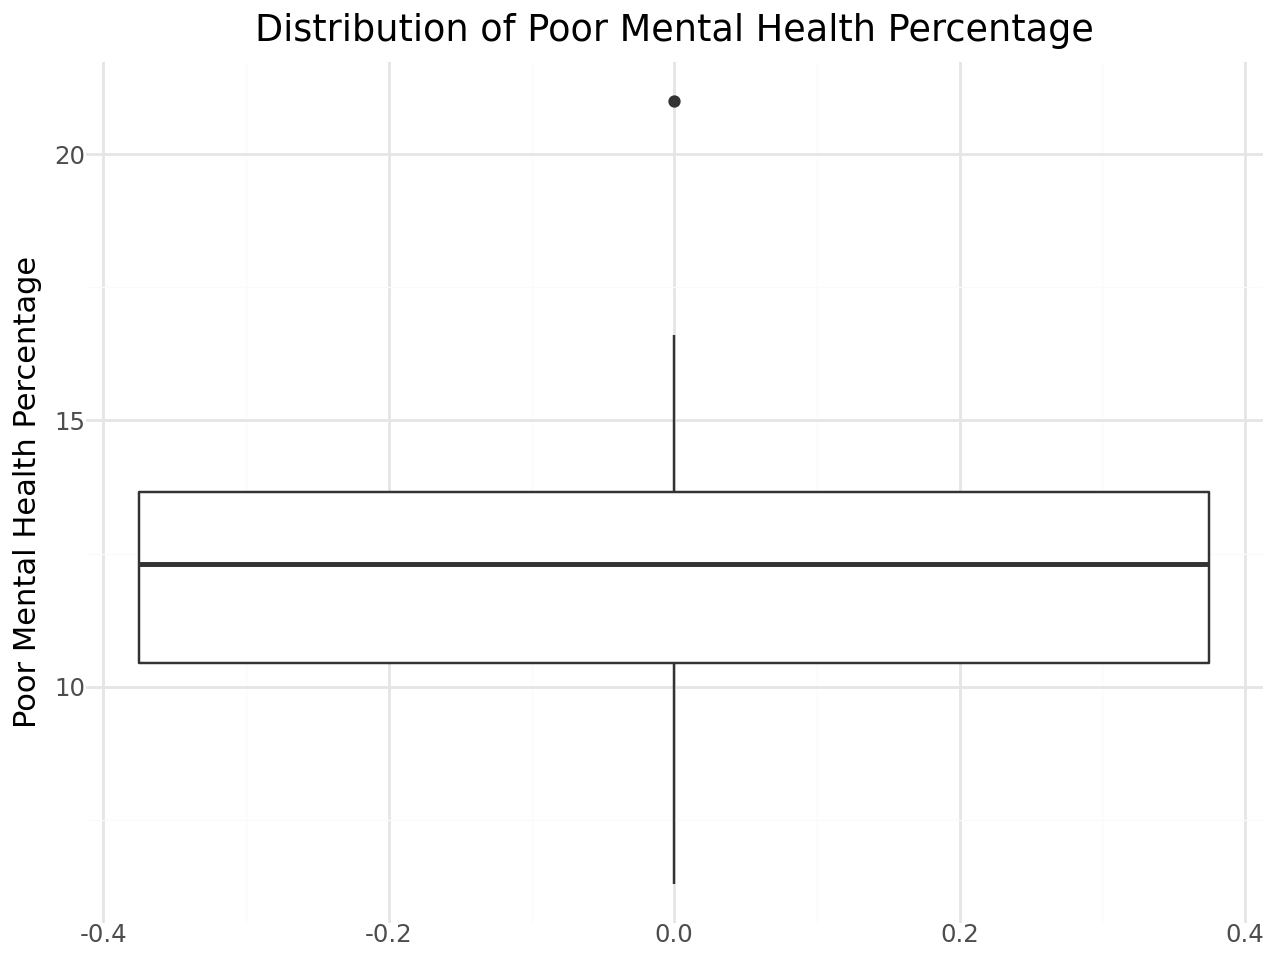

count    62.00
mean     12.06
std       2.65
min       6.30
25%      10.45
50%      12.30
75%      13.65
max      21.00
Name: Poor Mental Health Percentage, dtype: float64


C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


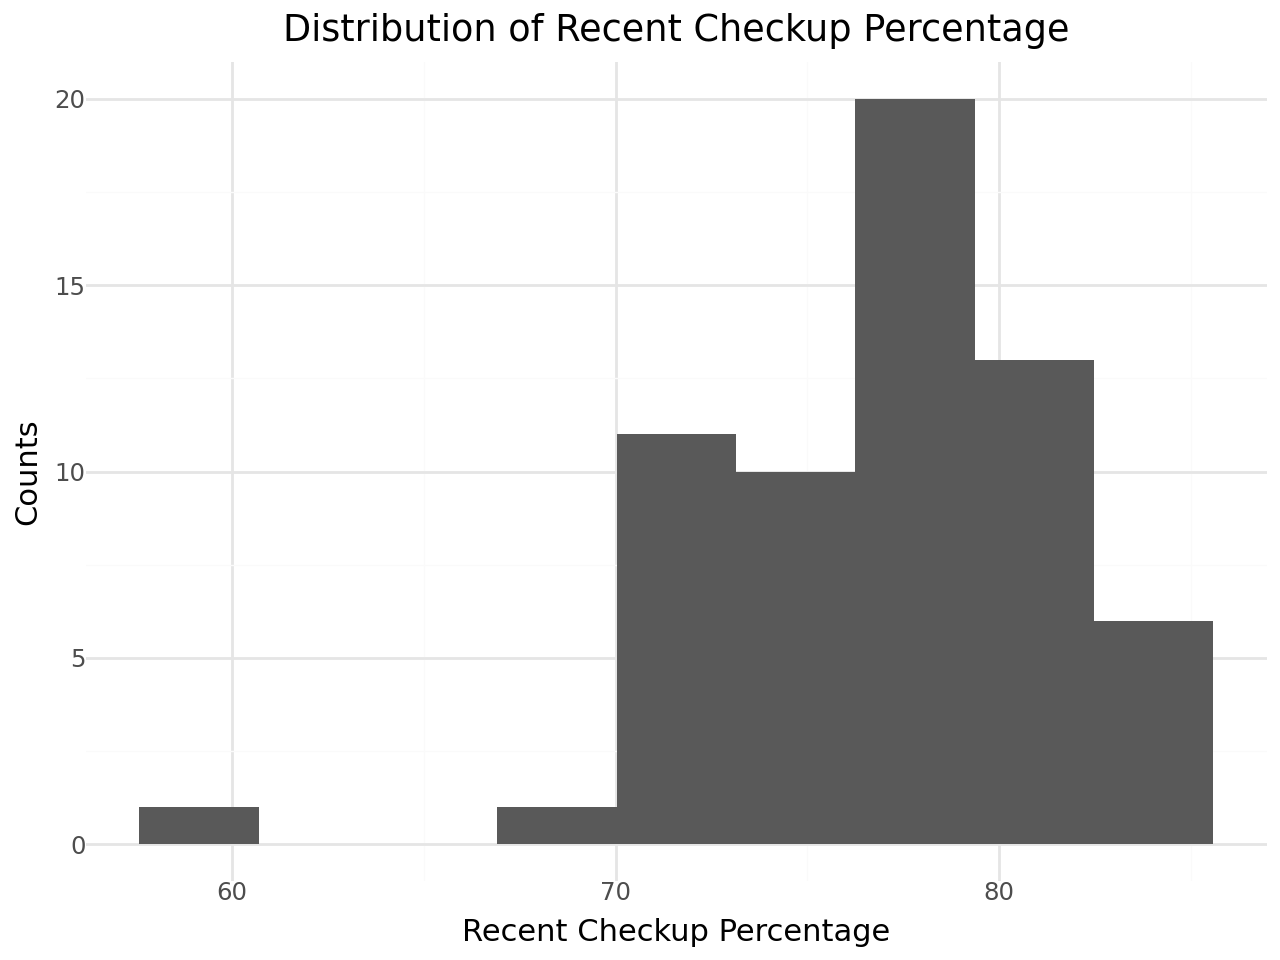

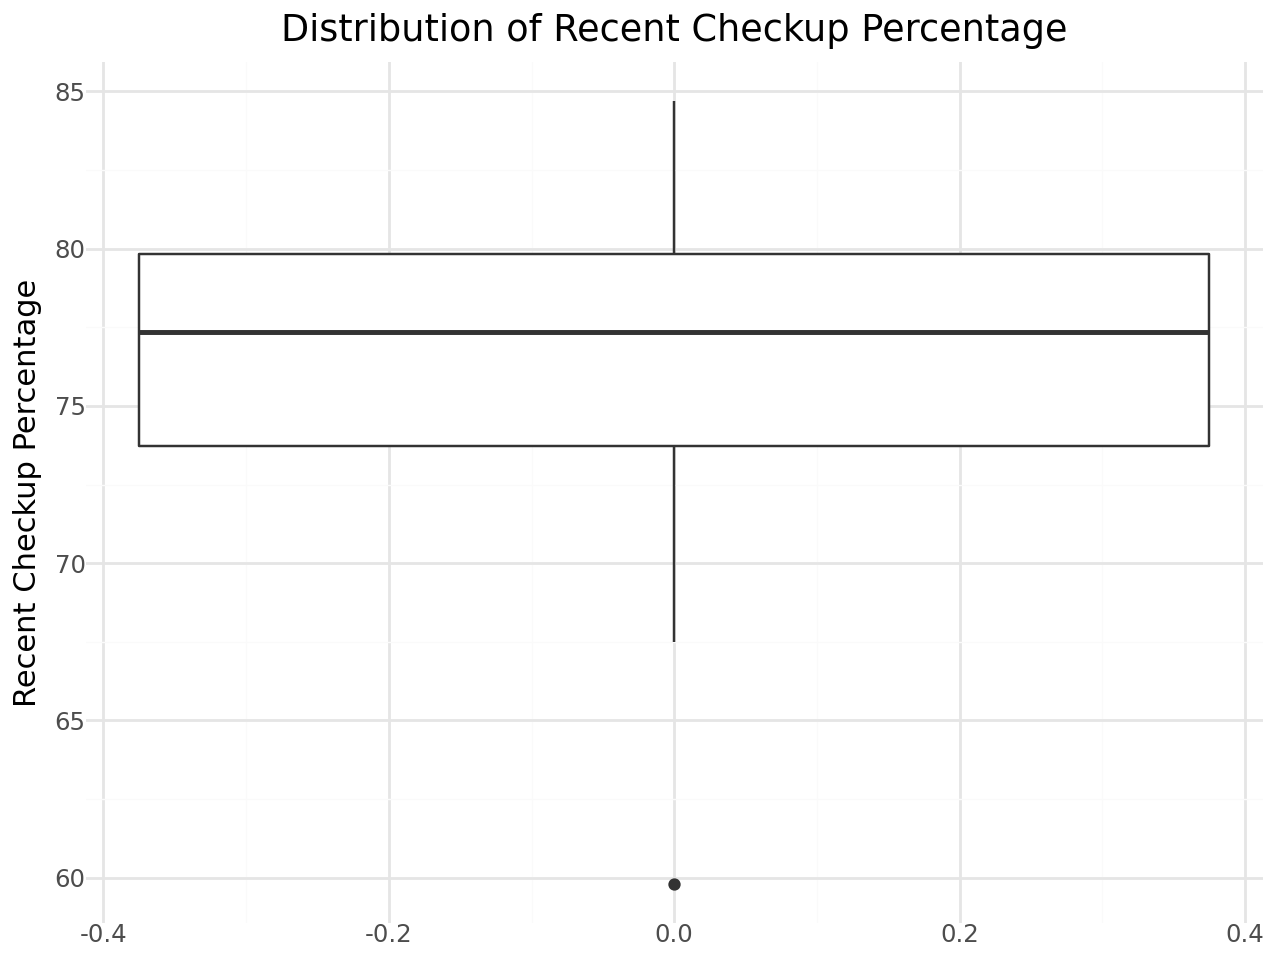

count    62.00
mean     76.85
std       4.40
min      59.80
25%      73.72
50%      77.35
75%      79.82
max      84.70
Name: Recent Checkup Percentage, dtype: float64


C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


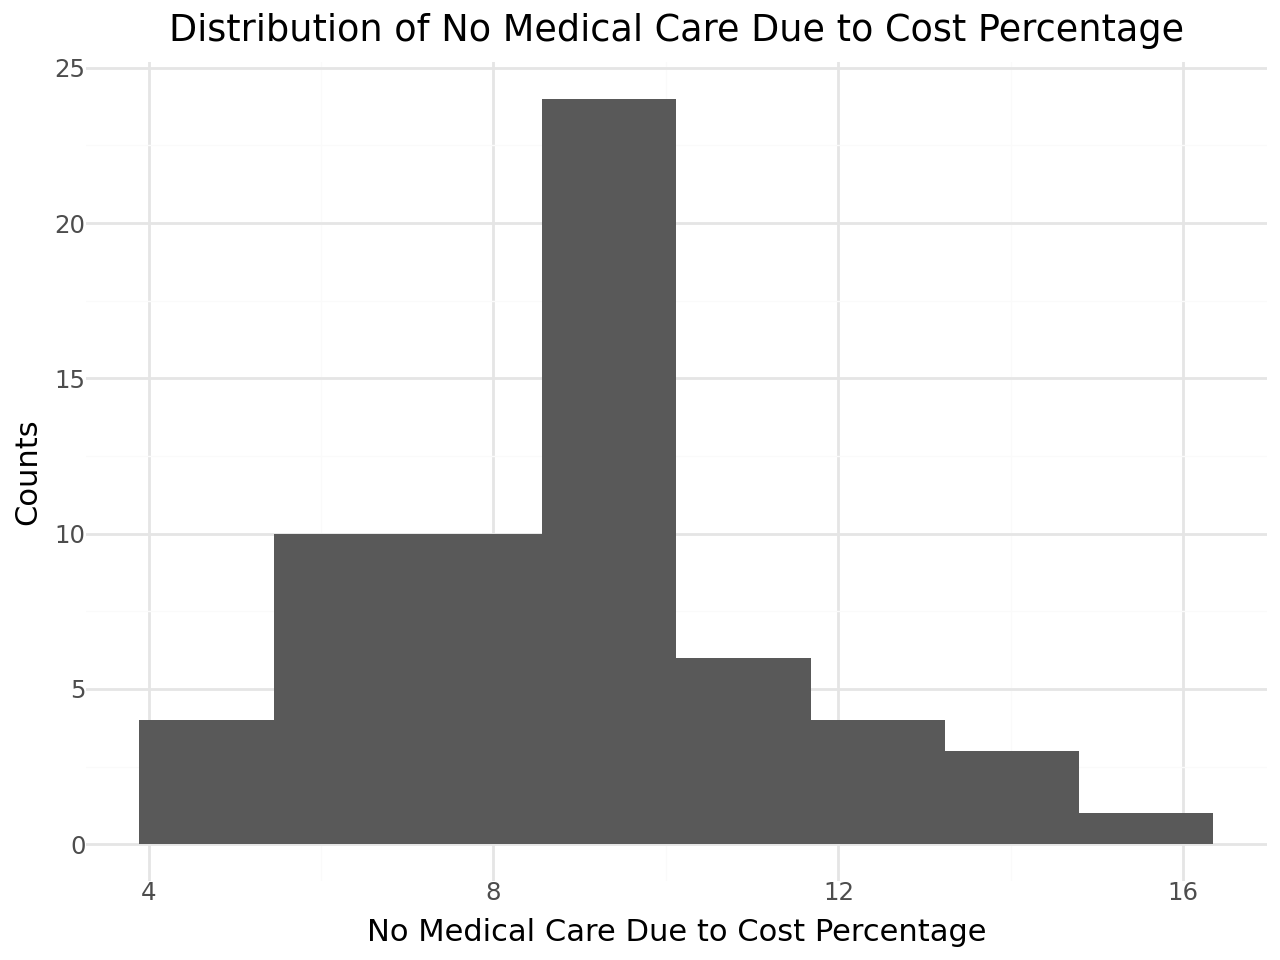

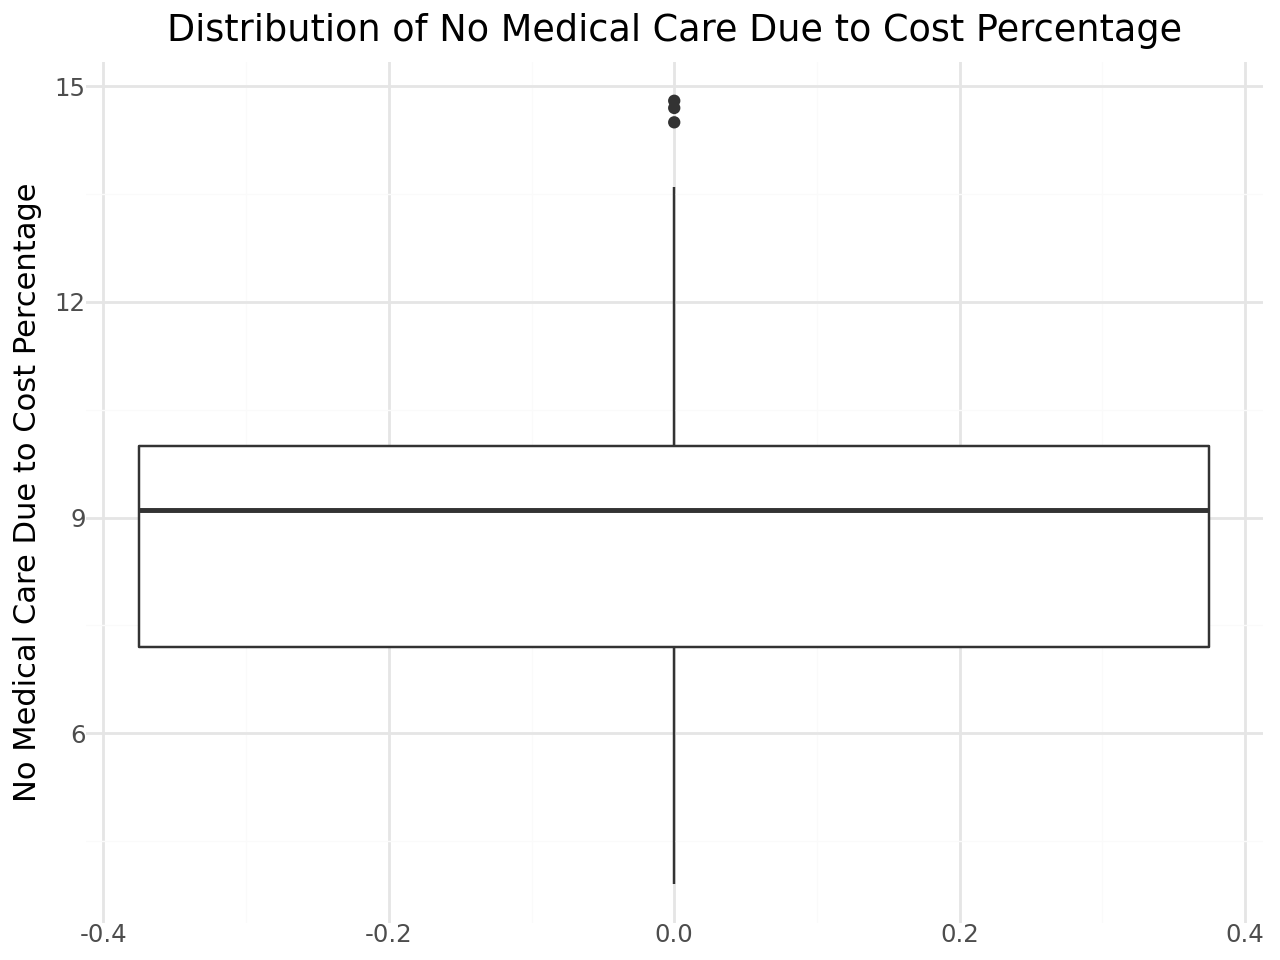

count    62.00
mean      9.00
std       2.42
min       3.90
25%       7.20
50%       9.10
75%      10.00
max      14.80
Name: No Medical Care Due to Cost Percentage, dtype: float64


In [19]:
def analysis_histogram(df, colname:str):
  return (ggplot(df, aes(x=colname)) +
        geom_histogram() +
        theme_minimal() +
        ggtitle('Distribution of ' + colname) +
        xlab(colname) +
        ylab('Counts'))

def analysis_boxplot(df, colname:str):
  return (ggplot(df, aes(y=colname)) +
        geom_boxplot() +
        theme_minimal() +
        ggtitle('Distribution of ' + colname))

# TODO: REFACTOR DISPLAYS INTO A FUNCTION


# OPIOIDS
plot = analysis_histogram(opioids_factors, 'Opioid Deaths per 100000')
plot.show()

plot = analysis_boxplot(opioids_factors, 'Opioid Deaths per 100000')
plot.show()

print(opioids_factors['Opioid Deaths per 100000'].describe().round(2))

# POVERTY
plot = analysis_histogram(opioids_factors, 'Poverty Percentage')
plot.show()

plot = analysis_boxplot(opioids_factors, 'Poverty Percentage')
plot.show()

print(opioids_factors['Poverty Percentage'].describe().round(2))

# EDUCATION
plot = analysis_histogram(opioids_factors, 'Dropout Percentage')
plot.show()

plot = analysis_boxplot(opioids_factors, 'Dropout Percentage')
plot.show()

print(opioids_factors['Dropout Percentage'].describe().round(2))

# MENTAL HEALTH
plot = analysis_histogram(opioids_factors, 'Poor Mental Health Percentage')
plot.show()

plot = analysis_boxplot(opioids_factors, 'Poor Mental Health Percentage')
plot.show()

print(opioids_factors['Poor Mental Health Percentage'].describe().round(2))

# RECENT CHECKUP
plot = analysis_histogram(opioids_factors, 'Recent Checkup Percentage')
plot.show()

plot = analysis_boxplot(opioids_factors, 'Recent Checkup Percentage')
plot.show()

print(opioids_factors['Recent Checkup Percentage'].describe().round(2))

# NO MEDICAL CARE DUE TO COST
plot = analysis_histogram(opioids_factors, 'No Medical Care Due to Cost Percentage')
plot.show()

plot = analysis_boxplot(opioids_factors, 'No Medical Care Due to Cost Percentage')
plot.show()

print(opioids_factors['No Medical Care Due to Cost Percentage'].describe().round(2))

Our data for opioid deaths per 100000 people is roughly normal and symmetric. There is one high outlier, but it is not extreme and does not appear to skew the dataset significantly, as the data's mean of 13.74 is quite close to its median of 13.50.

Our data for poverty percentages is roughly normal and symmetric. There is one high and one low outlier, but they are not extreme and do not appear to skew the dataset significantly, as the data's mean of 13.05 is quite close to its median of 12.95.

Our data for dropout percentages is roughly normal and symmetric. There are three high outliers and one low outlier, but they are not extreme and do not appear to skew the dataset significantly, as the data's mean of 2.45 is quite close to its median of 2.30.

Similarly, mental health, recent checkup, and lack of care due to cost data are roughly normal and symmetric. Each have one or two minor outliers, which do not significantly skew the dataset one way or the other.

# BIVARIATE ANALYSIS

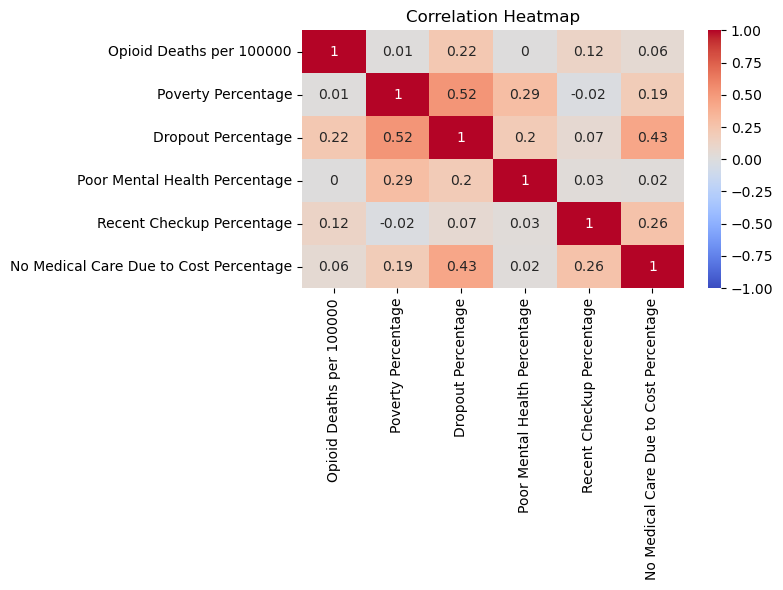

                          Opioid Deaths  Opioid Deaths per 100000  \
Opioid Deaths                      1.00                      0.31   
Opioid Deaths per 100000           0.31                      1.00   
Poverty Count                      0.88                      0.13   
Poverty Percentage                 0.08                      0.01   

                          Poverty Count  Poverty Percentage  
Opioid Deaths                      0.88                0.08  
Opioid Deaths per 100000           0.13                0.01  
Poverty Count                      1.00                0.29  
Poverty Percentage                 0.29                1.00  


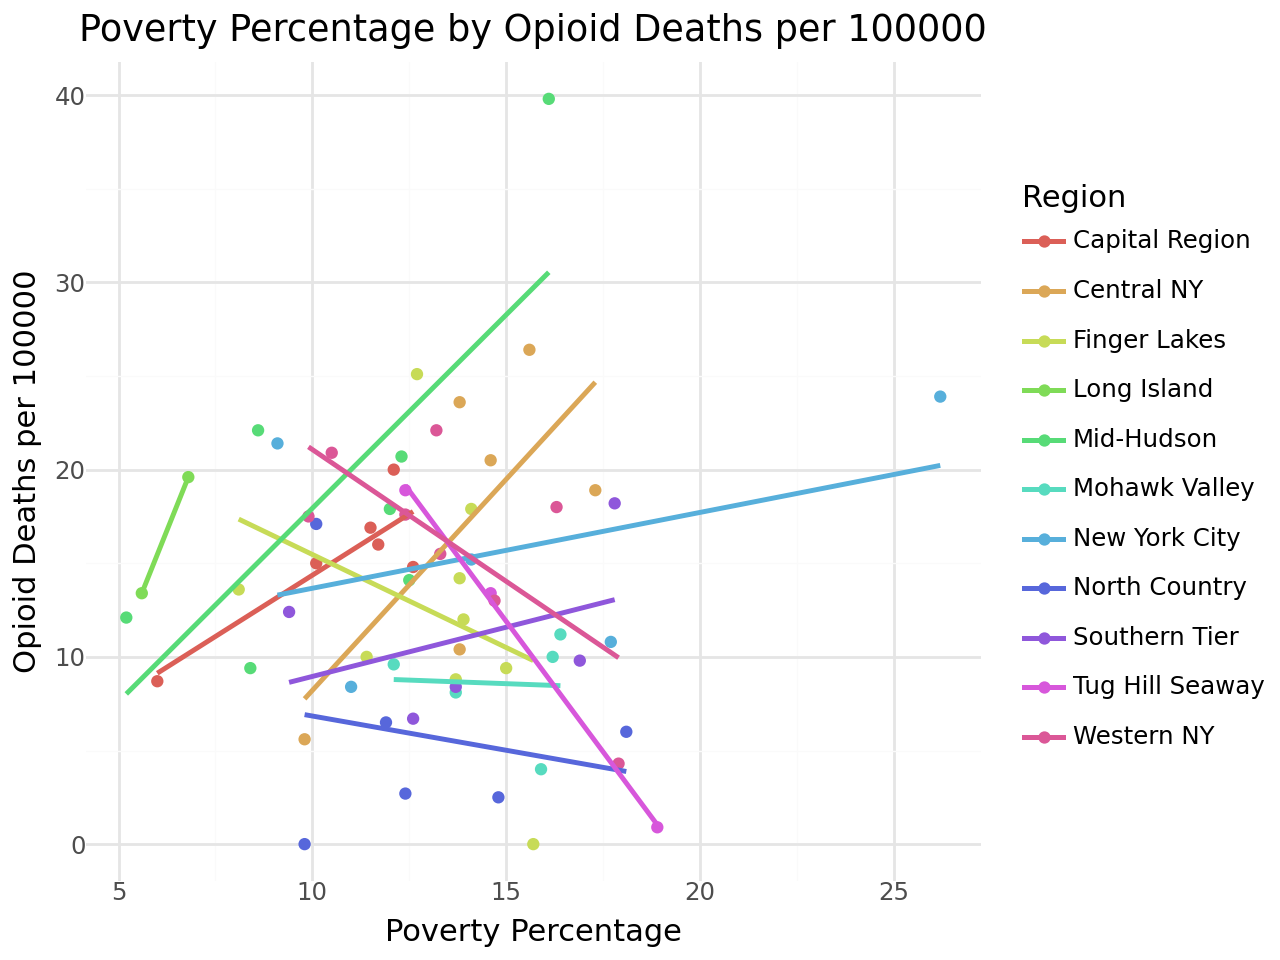

                          Opioid Deaths  Opioid Deaths per 100000  Dropouts  \
Opioid Deaths                      1.00                      0.31      0.91   
Opioid Deaths per 100000           0.31                      1.00      0.15   
Dropouts                           0.91                      0.15      1.00   
Dropout Percentage                 0.32                      0.22      0.44   

                          Dropout Percentage  
Opioid Deaths                           0.32  
Opioid Deaths per 100000                0.22  
Dropouts                                0.44  
Dropout Percentage                      1.00  


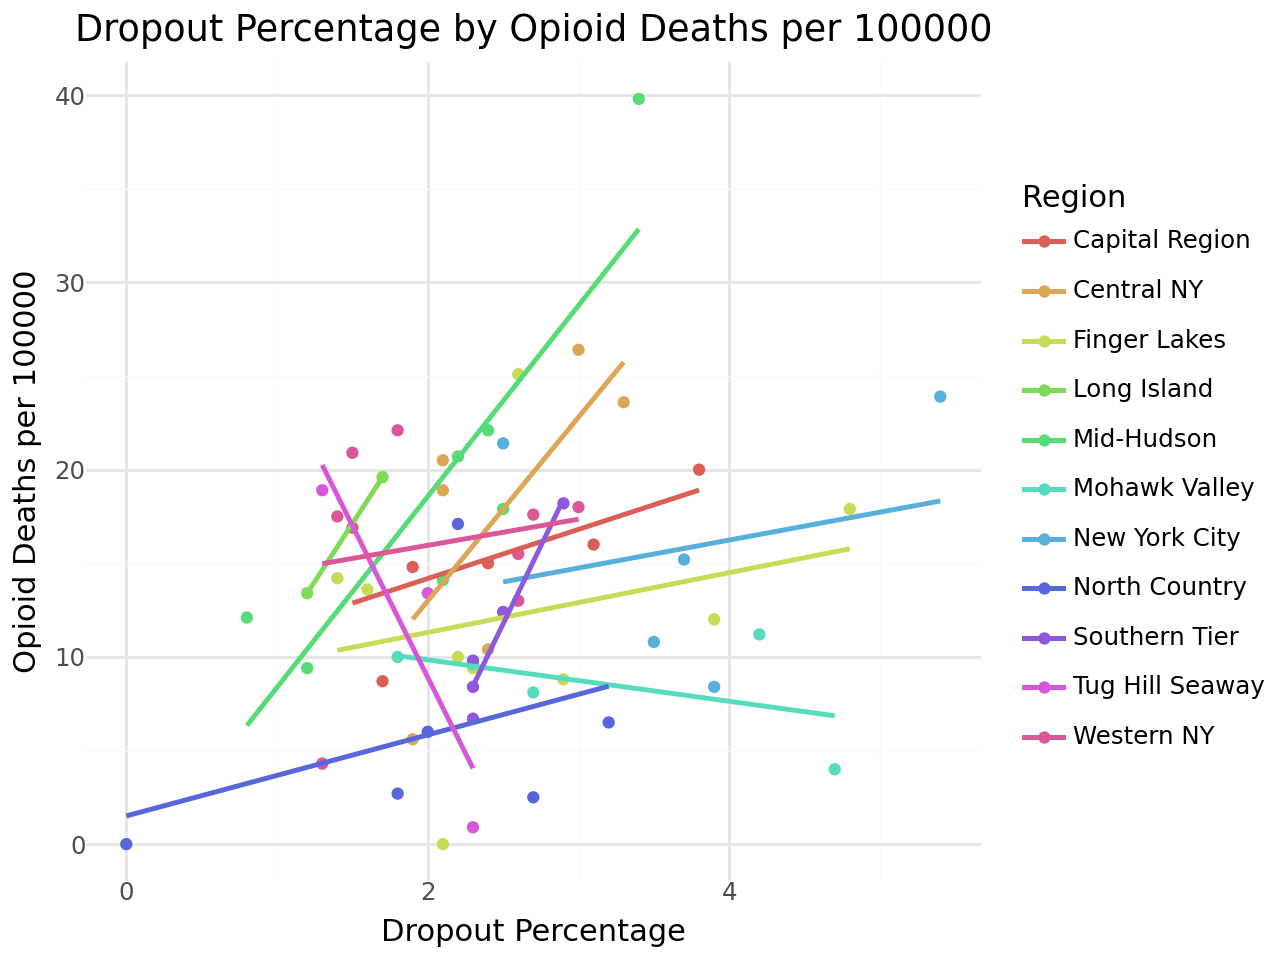

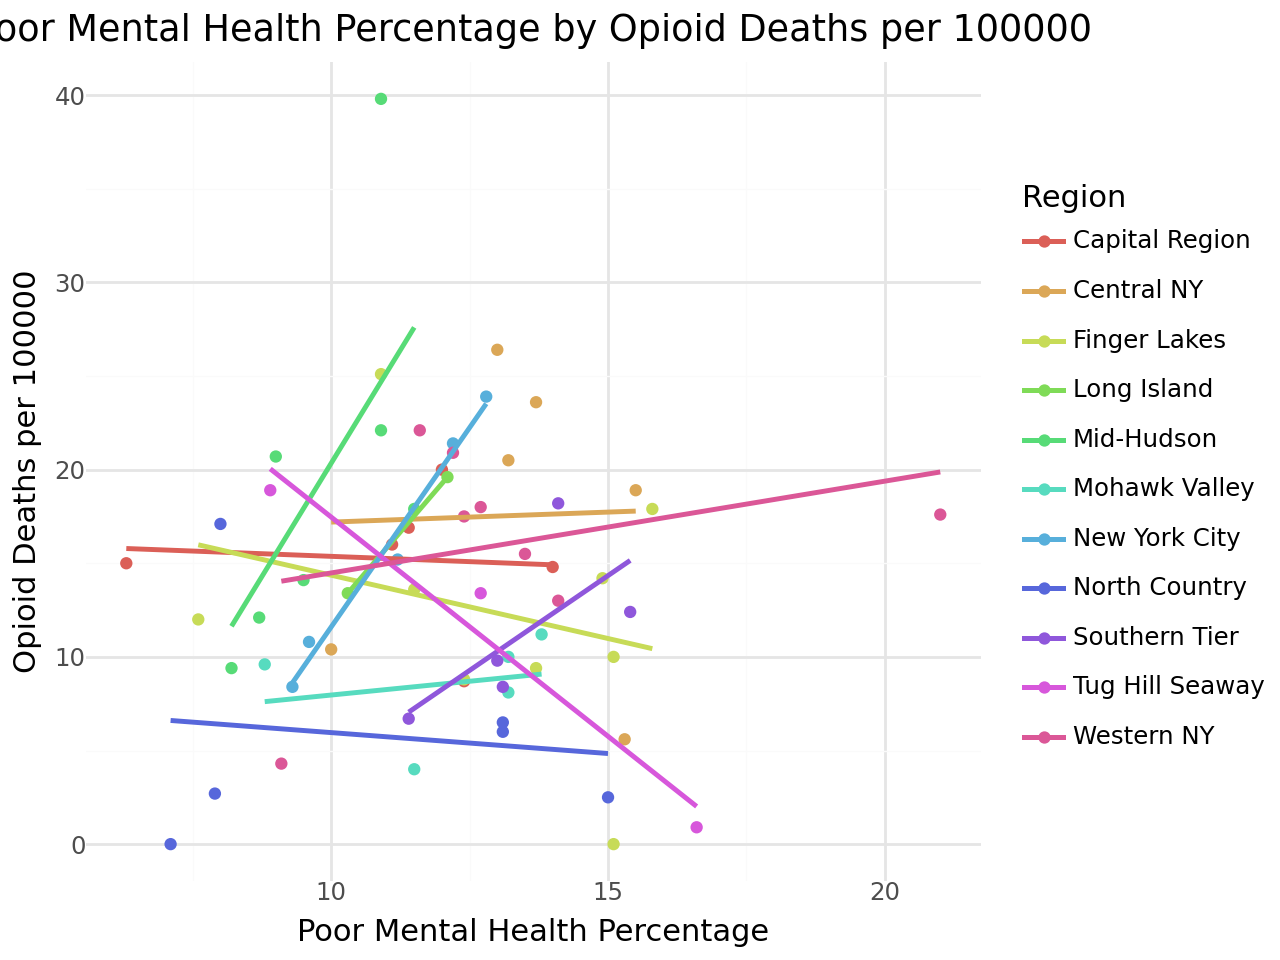

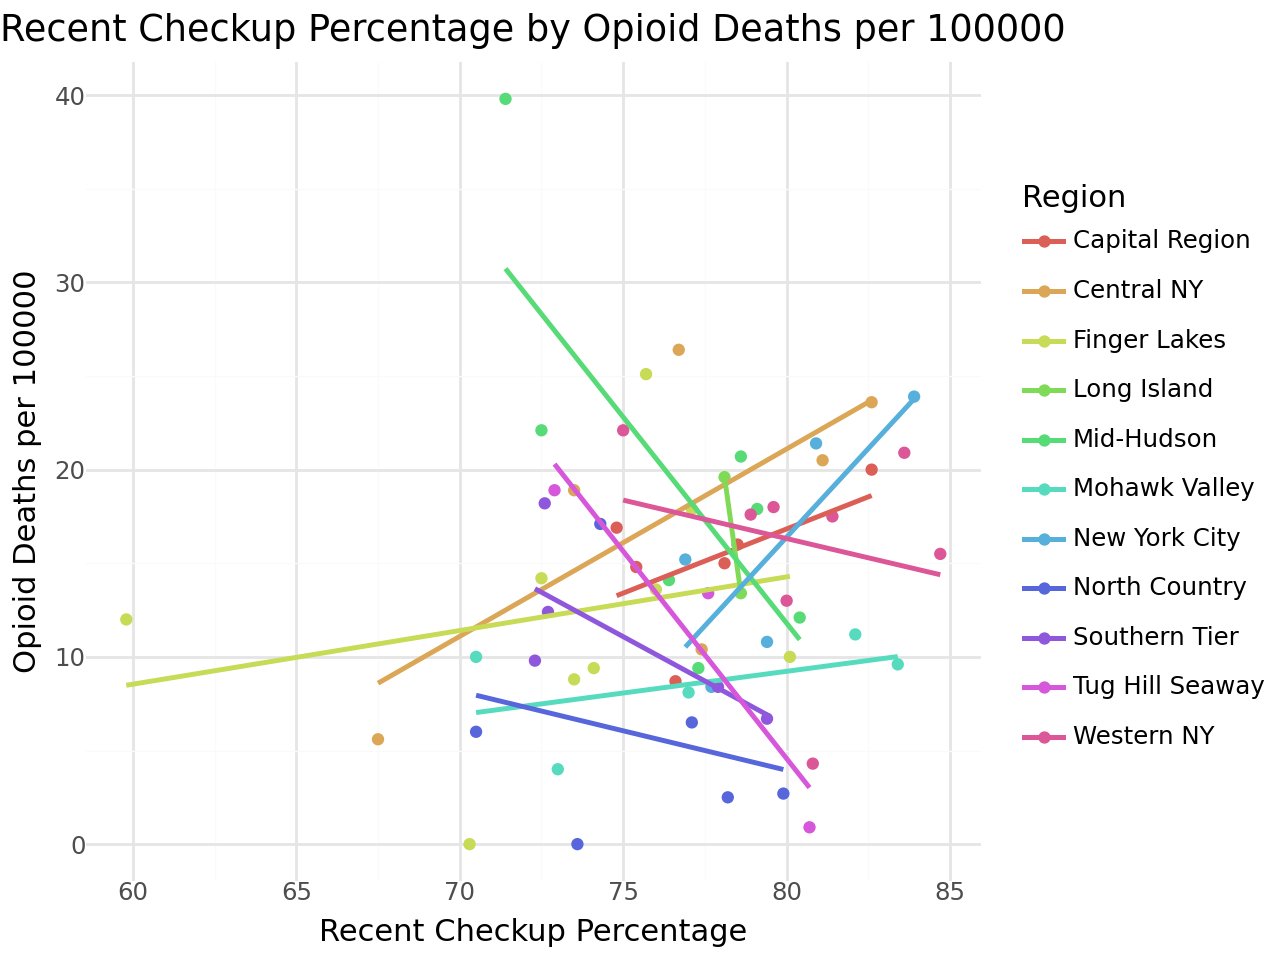

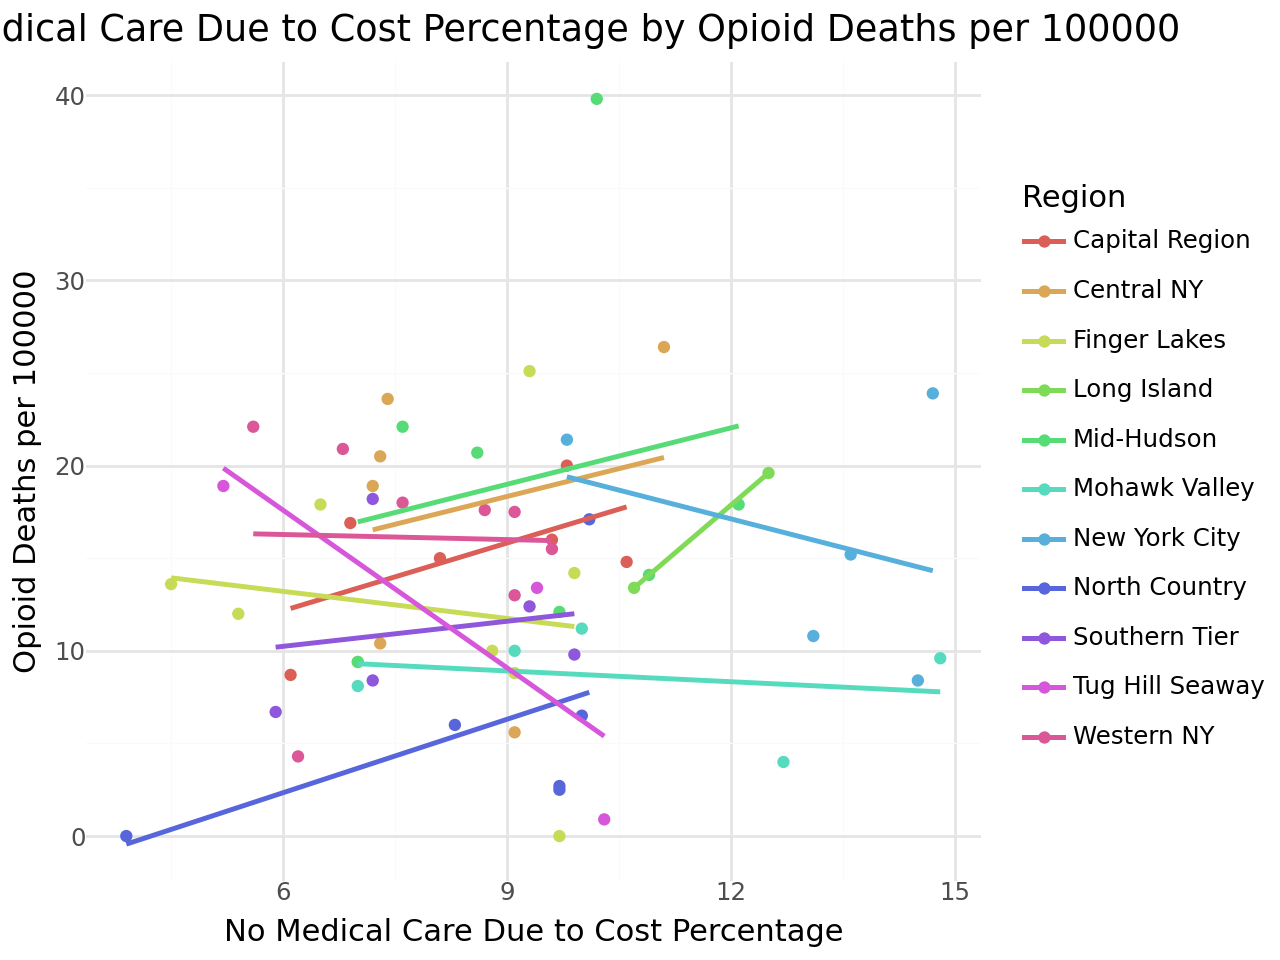

In [22]:
def analysis_scatterplot(df, xcol:str, ycol:str, strat):
  return (ggplot(df, aes(x=xcol, y=ycol, color=strat)) +
        geom_point() +
        geom_smooth(aes(group=strat), method='lm', se=False) +
        theme_minimal() +
        ggtitle(xcol + ' by ' + ycol) +
        xlab(xcol) +
        ylab(ycol))

# TODO: REFACTOR DISPLAYS INTO A FUNCTION


# RATES CORRELATIONS
corr = opioids_factors[[
    'Opioid Deaths per 100000',
    'Poverty Percentage',
    'Dropout Percentage',
    'Poor Mental Health Percentage',
    'Recent Checkup Percentage',
    'No Medical Care Due to Cost Percentage'
    ]].corr().round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


# OPIOIDS AND POVERTY
corr = opioids_factors[['Opioid Deaths','Opioid Deaths per 100000','Poverty Count','Poverty Percentage']].corr().round(2)
print(corr)

plot = analysis_scatterplot(opioids_factors, 'Poverty Percentage', 'Opioid Deaths per 100000', 'Region')
plot.show()


# OPIOIDS AND DROPOUTS
corr = opioids_factors[['Opioid Deaths','Opioid Deaths per 100000','Dropouts','Dropout Percentage']].corr().round(2)
print(corr)

plot = analysis_scatterplot(opioids_factors, 'Dropout Percentage', 'Opioid Deaths per 100000', 'Region')
plot.show()


# OPIOIDS AND MENTAL HEALTH
plot = analysis_scatterplot(opioids_factors, 'Poor Mental Health Percentage', 'Opioid Deaths per 100000', 'Region')
plot.show()


# OPIOIDS AND RECENT CHECKUP
plot = analysis_scatterplot(opioids_factors, 'Recent Checkup Percentage', 'Opioid Deaths per 100000', 'Region')
plot.show()


# OPIOIDS AND NO MEDICAL CARE
plot = analysis_scatterplot(opioids_factors, 'No Medical Care Due to Cost Percentage', 'Opioid Deaths per 100000', 'Region')
plot.show()

**Opioid death rate and poverty rate**

Opioid Deaths per 100000 and Poverty Percentage have a correlation coefficient of only 0.01, suggesting that there is no correlation between the variables.

Counts of opioid deaths and persons in poverty have a strong correlation of 0.88, but this is likely due to their shared underlying predictor of population size.

The scatterplot comparing opioid death rate and poverty rate, stratified by region, also reveals that there isn't much of a pattern. The points form a roughly circular cloud, with a few scattered outliers.

Poverty percentage and dropout percentage, however, have a moderate correlation of 0.52 (r<sup>2</sup> of 0.27). So, poverty may have some predictive power for dropout rates, but it appears to have no such power for opioid death rates, our response variable.

At this point, it doesn't appear that poverty rate is a reliable predictor of opioid death rate.

</br>

**Opioid death rate and dropout rate**

Opioid Deaths per 100000 and Dropout Percentage have a correlation coefficient of 0.22 (r<sup>2</sup> of 0.05), suggesting a weak positive correlation.

Counts of opioid deaths and dropouts have a strong correlation of 0.91, but this is likely due to their shared underlying predictor of population size.

Interestingly, raw counts of opioid deaths and dropout percentage have a correlation of 0.32, higher than the correlation between rates. Perhaps population size is a good true predictor of dropout percentage, not just raw dropout counts. However, we're interested in opioid death rate as our response variable, so we won't investigate this hunch further.

The scatterplot comparing opioid death rate and dropout rate, stratified by region, also reveals that there isn't much of a pattern. The points form a roughly circular cloud, with a few scattered outliers.

At this point, it doesn't appear that dropout rate on its own is a reliable predictor of opioid death rate.

</br>

**Opioid death rate and poor mental health rate**

Opioid Deaths per 100000 and Poor Mental Health Percentage have a correlation coefficient of 0.0, suggesting no correlation.

The scatterplot comparing opioid death rate and poor mental health rate, stratified by region, also reveals that there isn't much of a pattern. The points form a roughly circular cloud, with a few scattered outliers.

At this point, it doesn't appear that poor mental health rate is a reliable predictor of opioid death rate.

</br>

**Opioid death rate and recent checkup rate**

Opioid Deaths per 100000 and Recent Checkup Percentage have a correlation coefficient of 0.12 (r<sup>2</sup> of 0.01), suggesting a weak positive correlation.

The scatterplot comparing opioid death rate and recent checkup rate, stratified by region, also reveals that there isn't much of a pattern. The points form a roughly circular cloud, with a few scattered outliers.

It is interesting that this correlation, while weak, is positive, not negative. So, as a county has more regular checkups, it also tends to have more opioid related deaths. Again, this correlation is very weak

At this point, it doesn't appear that recent checkup rate on its own is a reliable predictor of opioid death rate.

</br>

**Opioid death rate and lack of access to medical care due to cost rate**

Opioid Deaths per 100000 and No Medical Care Due to Cost Percentage have a correlation coefficient of 0.06, suggesting no correlation.

The scatterplot comparing opioid death rate and lack of medical care due to cost, stratified by region, also reveals that there isn't much of a pattern. The points form a roughly circular cloud, with a few scattered outliers.

At this point, it doesn't appear that rate of lack of medical care due to cost is a reliable predictor of opioid death rate.


# REGRESSIONS

We still have more significant opioid death rate predictors to find, but I'll start with Dropout Percentage (r of 0.22) and Recent Checkup Percentage (r of 0.12) as they are the only predictors with any degree of correlation at all. As I find more interesting predictors, it'll be easy to add them to the model as another way to analyze this data.

Our two predictors have a correlation of only 0.07 with one another, so the effect of partial correlation within our features is negligible.

In [25]:
# feature selection
y = opioids_factors['Opioid Deaths per 100000']
X = opioids_factors[[
    'Dropout Percentage',
    'Recent Checkup Percentage'
]]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

# train linear model
model = LinearRegression()
model.fit(X_train, y_train)

# generate predictions
y_pred = model.predict(X_test)

# evaluate model
print("Coefficients: ", model.coef_.round(2))
print("Intercept: ", model.intercept_.round(2))
print("MSE: ", mean_squared_error(y_test, y_pred).round(2))
print("R2: ", r2_score(y_test, y_pred).round(2))

Coefficients:  [0.58 0.24]
Intercept:  -6.27
MSE:  78.42
R2:  0.06


# RESULTS

In this analysis, we explored the relationship between opioid overdose deaths and various socio-economic factors across New York counties. Specifically, we looked at poverty rates, high school dropout rates, mental health indicators, and access to healthcare as potential predictors of opioid deaths per 100,000 people.

**Univariate Analysis**

Our univariate analysis revealed that the distributions of opioid deaths, poverty percentages, dropout percentages, mental health, recent checkup percentages, and lack of medical care due to cost were all roughly normal and symmetric. This normality and symmetry suggest that the data is suitable for further statistical analysis. There were a few outliers, but they were not numerous or extreme enough to skew the results significantly.

**Bivariate Analysis**

In examining the correlations between opioid death rates and each socio-economic factor, the following observations were made:

**Opioid Death Rate and Poverty Rate:**

The correlation coefficient between opioid deaths per 100,000 people and poverty percentage was 0.01, suggesting no significant correlation.
A strong correlation (0.88) between raw counts of opioid deaths and poverty counts likely reflects underlying population size rather than a direct relationship between poverty and opioid deaths.
Scatterplots did not reveal any discernible pattern or trend, further supporting the lack of correlation.

**Opioid Death Rate and High School Dropout Rate:**

The correlation between opioid deaths per 100,000 people and dropout percentage was 0.22 (r² of 0.05), indicating a weak positive correlation.
Strong correlations between raw counts of opioid deaths and dropouts (0.91) again suggest that population size is a confounding factor.
Scatterplots showed a weak positive trend, but overall, no strong pattern was evident.

**Opioid Death Rate and Poor Mental Health Rate:**

A correlation coefficient of 0.00 between opioid deaths and poor mental health percentage suggests no correlation.
Scatterplots further confirmed the absence of a clear relationship.

**Opioid Death Rate and Recent Checkup Rate:**

A weak positive correlation of 0.12 (r² of 0.01) was observed between opioid deaths and recent checkup percentages. Interestingly, the positive correlation suggests that counties with higher regular checkup rates might actually experience higher opioid death rates, though this correlation is very weak.

**Opioid Death Rate and Lack of Access to Medical Care Due to Cost:**

A correlation of 0.06 indicates no significant relationship between opioid deaths and the percentage of people unable to access medical care due to cost. Scatterplots confirmed the lack of a clear pattern.

**Regression Analysis**

Using our weak correlations, we performed a multiple linear regression analysis using Dropout Percentage and Recent Checkup Percentage as predictors. The regression model confirmed that these variables, while weakly correlated with opioid deaths, do not provide a strong predictive capability for opioid death rates. The low R² value (0.06) indicates that a significant portion of the variance in opioid death rates remains unexplained by these factors alone.

More significant predictors will be added to the regression model as they are discovered.



# CONCLUSION

Our analysis aims to determine whether socio-economic factors such as poverty rates, high school dropout rates, mental health, and healthcare access could serve as reliable predictors of opioid overdose deaths across New York State counties. Currently, the results indicate that none of these factors, in isolation, show a strong correlation with opioid death rates. This finding underscores the complexity of the opioid crisis, suggesting that it is influenced by a combination of factors not fully captured in this dataset.

**Recommendations**

Broader Data Collection: Future research should include additional variables such as unemployment rates, chronic pain prevalence, and substance abuse treatment availability. In particular, the weak correlation of high school dropout rate to opioid death rate may indicate the presence of stronger predictors linked to both high school dropout rate and opioid death rate. Unemployment rates, intuitively, sound like one such candidate to explore. Overall, though, a more comprehensive dataset should better capture the multifaceted nature of opioid addiction.

More Targeted Analysis: While analysis of county-level data for the entire state did not show significant patterns, it's possible that more targeted county-level data within each region may show different patterns, as different regions within New York may be subject to different conditions.

Broad Interventions: Given the weak correlations, interventions should not focus solely on socio-economically disadvantaged counties. Instead, they should address the issue across all demographics, recognizing that opioid addiction can affect diverse populations.

Public Health Messaging: The results highlight the need for public health campaigns to frame opioid addiction as a widespread issue, rather than one confined to specific socio-economic groups. Efforts should focus on reducing stigma and increasing awareness of the risk factors and signs of addiction for individuals.

In conclusion, opioid addiction remains a significant public health crisis that transcends socio-economic boundaries. This crisis demands a large-scale, coordinated response from public health authorities to address the pervasive nature of opioid addiction effectively.